In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# set up dataframes
# https://www.kaggle.com/datasets/christophercorrea/prisoners-and-crime-in-united-states
JailDeaths = pd.read_csv("datasets/all_deaths.csv", encoding='latin-1')
JailStats = pd.read_csv("datasets/all_jails.csv", encoding='latin-1')

# https://www.kaggle.com/datasets/noriuk/us-education-datasets-unification-project
Education_ByState = pd.read_csv("datasets/states_all.csv", encoding='latin-1')

# https://bjs.ojp.gov/library/publications/prisoners-2021-statistical-tables#:~:text=The%20U.S.%20prison%20population%20was,decrease%20from%202011%20(1%2C599%2C000)
p21stt01 = pd.read_csv("datasets/p21stt01.csv", encoding='latin-1')
p21stat02 = pd.read_csv("datasets/p21stat02.csv", encoding='latin-1')

Education_ByState

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,NaN,NaN,731634.0,208.0,252.0,207.0,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,NaN,NaN,122487.0,NaN,NaN,NaN,NaN
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,NaN,NaN,673477.0,215.0,265.0,209.0,NaN
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,NaN,NaN,441490.0,210.0,256.0,211.0,NaN
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,NaN,NaN,5254844.0,208.0,261.0,202.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,2019_VIRGINIA,VIRGINIA,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,247.0,287.0,224.0,262.0
1711,2019_WASHINGTON,WASHINGTON,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,240.0,286.0,220.0,266.0
1712,2019_WEST_VIRGINIA,WEST_VIRGINIA,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,231.0,272.0,213.0,256.0
1713,2019_WISCONSIN,WISCONSIN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,242.0,289.0,220.0,267.0


In [49]:
# clean up states_all_extended
# set columns
Education_ByState.columns = [
    "State Key",
    "State",
    "Year",
    "Total Enrollment",
    "Total Revenue",
    "Federal Revenue",
    "State Revenue",
    "Local Revenue",
    "Total Expenditure",
    "Instruction Expenditure",
    "Support Services Expenditure",
    "Other Expenditure",
    "Capital Outlay Expenditure",
    "Total Enrollment (Pre-K)",
    "Total Enrollment (K)",
    "Total Enrollment (4)",
    "Total Enrollment (8)",
    "Total Enrollment (12)",
    "Total Enrollment (1-8)",
    "Total Enrollment (9-12)",
    "Total Enrollment (ALL)",
    "Average Math Score (4)",
    "Average Math Score (8)",
    "Average Reading Score (4)",
    "Average Reading Score (8)",
]

In [54]:
##Education Dataset Cleanup
Education_ByStateCleaned = Education_ByState.drop(['State Key', 'Total Enrollment'], axis = 1)
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['Year'] <= 2016]
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['Year'] >= 1992]
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['State'] != 'NATIONAL']
Education_ByStateCleaned = Education_ByStateCleaned[Education_ByStateCleaned['State'] != 'DODEA']
Education_ByStateCleaned

,State,Year,Total Revenue,Federal Revenue,State Revenue,Local Revenue,Total Expenditure,Instruction Expenditure,Support Services Expenditure,Other Expenditure,...,Total Enrollment (4),Total Enrollment (8),Total Enrollment (12),Total Enrollment (1-8),Total Enrollment (9-12),Total Enrollment (ALL),Average Math Score (4),Average Math Score (8),Average Reading Score (4),Average Reading Score (8)
0,ALABAMA,1992,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,735036.0,NaN,...,57948.0,58025.0,41167.0,NaN,NaN,731634.0,208.0,252.0,207.0,NaN
1,ALASKA,1992,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,350902.0,NaN,...,9748.0,8789.0,6714.0,NaN,NaN,122487.0,NaN,NaN,NaN,NaN
2,ARIZONA,1992,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,1007732.0,NaN,...,55433.0,49081.0,37410.0,NaN,NaN,673477.0,215.0,265.0,209.0,NaN
3,ARKANSAS,1992,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,483488.0,NaN,...,34632.0,36011.0,27651.0,NaN,NaN,441490.0,210.0,256.0,211.0,NaN
4,CALIFORNIA,1992,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,8520926.0,NaN,...,418418.0,363296.0,270675.0,NaN,NaN,5254844.0,208.0,261.0,202.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,VIRGINIA,2016,16259274.0,1058146.0,6297587.0,8903541.0,16497520.0,8944614.0,5164699.0,643506.0,...,99258.0,95234.0,90500.0,773615.0,389330.0,1287026.0,NaN,NaN,NaN,NaN
1271,WASHINGTON,2016,14964364.0,1097684.0,9211201.0,4655479.0,15253296.0,7087365.0,4904575.0,577606.0,...,86114.0,81039.0,90645.0,667327.0,339349.0,1101711.0,NaN,NaN,NaN,NaN
1272,WEST_VIRGINIA,2016,3391579.0,358068.0,1863062.0,1170449.0,3366566.0,1804235.0,1127255.0,236487.0,...,20324.0,19931.0,18155.0,159595.0,79442.0,273855.0,NaN,NaN,NaN,NaN
1273,WISCONSIN,2016,11697466.0,782610.0,5986763.0,4928093.0,11787535.0,5760418.0,3691439.0,508013.0,...,62408.0,61432.0,66303.0,488983.0,262681.0,864432.0,NaN,NaN,NaN,NaN


C:\Users\Andrew\AppData\Local\Temp\ipykernel_12456\1310746225.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EducationExp['Total Enrollment'] = EducationExp['Total Enrollment'].fillna(EducationExp['Total Enrollment (ALL)'])


Text(0.5, 0, 'State')

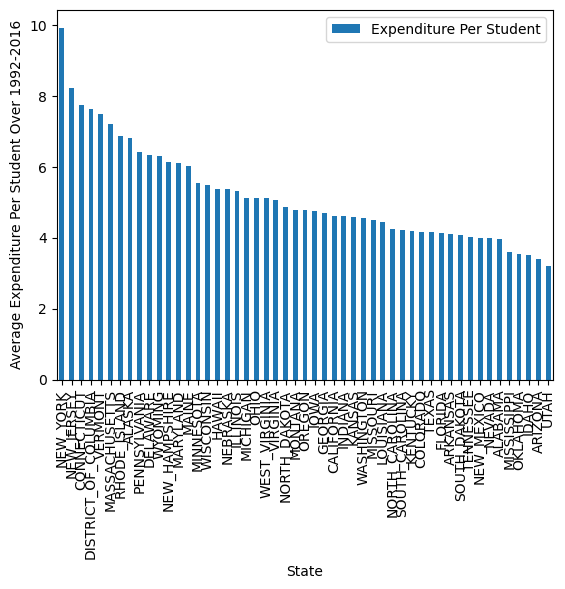

In [95]:
##Exploring The Data

##Expenditure Per Student By State
EducationExp = Education_ByState

#Dropping rows that have NA values for Instruction Expenditure
EducationExp = EducationExp.dropna(subset= ['Instruction Expenditure'])

##Filtering Rows that have NAs for both enrollment estimates then filling one rows NAs with the other rows estimates. 
EducationExp[pd.notna(EducationExp['Total Enrollment']) | pd.notna(EducationExp['Total Enrollment (ALL)'])]
EducationExp['Total Enrollment'] = EducationExp['Total Enrollment'].fillna(EducationExp['Total Enrollment (ALL)'])
EducationExp.drop(['Total Enrollment (ALL)'], axis = 1)

#Selecting appropriate columns
EducationExp = EducationExp[['State', 'Year', 'Total Enrollment', 'Instruction Expenditure']]

#Create Expenditure By Student
EducationExp['Expenditure Per Student'] = EducationExp['Instruction Expenditure'] / EducationExp['Total Enrollment']
EducationExpGroupby = EducationExp.groupby('State').mean()
EducationExpGroupby = EducationExpGroupby.reset_index().sort_values('Expenditure Per Student', ascending= False)

EducationExpGroupby.index = EducationExpGroupby['State'] 
#Graphing
#RESTYLE PLOT
import matplotlib.pyplot as plt
EducationExpGroupby = EducationExpGroupby[['State', 'Expenditure Per Student']]
EducationExpGroupby.plot.bar()
plt.ylabel("Average Expenditure Per Student Over 1992-2016")
plt.xlabel("State")